## Sales Prediction using a Machine Learning Algorithm(s)

In [1]:
import pickle
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from time import gmtime, strftime
import matplotlib.pyplot as plt
import datetime


In [2]:
import os, sys
import warnings
sys.path.append(os.path.abspath(os.path.join('../scripts')))
warnings.filterwarnings('ignore')

from preprocessing import Preprocessing
from plot import Plot
import dvc.api

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import pickle
from logger import Logger

In [3]:
# instantiate Preprocessing object
preprocess = Preprocessing()

# instantiate Plot object
plot = Plot()

#
logger = Logger("../logs/mlprediction.log").get_app_logger()


In [4]:
# Get url from dvc
path = 'data/cleaned_train.csv'
repo = 'https://github.com/YohansSamuel/pharmaceutical_sales_prediction'
version = 'cleaned-v'

# Load data from dvc
# data_url = dvc.api.get_url(path=path,repo=repo,rev=version)


In [5]:
# load the cleaned dataset
try:
    df_train = preprocess.read_csv('../data/cleaned_train.csv')
    df_test = preprocess.read_csv('../data/cleaned_test.csv')
    logger.exception('load data successfully')
except:
    logger.exception('Failed to load dataset')


file read as csv
file read as csv


In [6]:
df_train.head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,Year,Month,Day,weekday,weekofyear,weekend,PromoInterval,Assortment,StoreType,Decile_rank
0,1,1,0.0,0.0,0,0,a,1,1270.0,9.0,...,2013,1,1,1,1,0,1,0,2,1
1,1,2,5530.0,668.0,1,0,0,1,1270.0,9.0,...,2013,1,2,2,1,0,1,0,2,1
2,1,3,4327.0,578.0,1,0,0,1,1270.0,9.0,...,2013,1,3,3,1,0,1,0,2,1
3,1,4,4486.0,619.0,1,0,0,1,1270.0,9.0,...,2013,1,4,4,1,0,1,0,2,1
4,1,5,4997.0,635.0,1,0,0,1,1270.0,9.0,...,2013,1,5,5,1,1,1,0,2,1


In [7]:
try:
    df_train.drop(['StateHoliday'], axis=1, inplace=True)
    df_train.dtypes
    logger.info('dropped the column successfully')
except:
    logger.exception('Failed to load drop the column')

In [8]:
# remove rows that have closed stores and sales = 0
try:
    df_train = df_train[df_train['Open'] == 1]
    df_train = df_train[df_train['Sales'] > 0.0]
    logger.info('dropped the column successfully')
except:
    logger.exception('Failed to load drop the column')

In [9]:
# label encode the 'Date' column
try:
    # Label encode Date in both training and testing datasets
    for dataset in (df_train, df_test):
        encoder = preprocessing.LabelEncoder()
        dataset['Date'] = encoder.fit_transform(dataset['Date'])
    logger.info("Date is encoded successfully.")
            
except Exception as e:
    logger.exception(f'Exception occured in Date encoding!, {e}')

In [10]:
scaler = MinMaxScaler()
trainining_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',\
                    'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',\
                    'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year', 'DayOfYear', 'WeekOfYear']

testing_columns = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday','SchoolHoliday', 'StoreType', 'Assortment',\
                  'CompetitionDistance','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', \
                  'Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year', 'DayOfYear', 'WeekOfYear']

train_data = df_train.copy()
test_data = df_test.copy()   

try:
    for i in trainining_columns:
    
        # fit on training data column
        scale = scaler.fit(train_data[[i]])
        
        # transform the training data column
        train_data[i] = scale.transform(train_data[[i]])
    
    for i in testing_columns:
    
        # fit on training data column
        scale = scaler.fit(test_data[[i]])
        
        # transform the training data column
        test_data[i] = scale.transform(test_data[[i]]) 
    
    logger.debug("Data is Normalized successfully.")
    
except Exception as e:
    logger.debug(f"Exception occured while Normalizing the dataset, {e}")

In [11]:
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Year,Month,Day,weekday,weekofyear,weekend,PromoInterval,Assortment,StoreType,Decile_rank
1,0.0,0.333333,5530.0,668.0,1,0,1,1270.0,9.0,2008.0,...,2013,1,2,2,1,0,1,0,2,1
2,0.0,0.500000,4327.0,578.0,1,0,1,1270.0,9.0,2008.0,...,2013,1,3,3,1,0,1,0,2,1
3,0.0,0.666667,4486.0,619.0,1,0,1,1270.0,9.0,2008.0,...,2013,1,4,4,1,0,1,0,2,1
4,0.0,0.833333,4997.0,635.0,1,0,1,1270.0,9.0,2008.0,...,2013,1,5,5,1,1,1,0,2,1
6,0.0,0.000000,7176.0,785.0,1,1,1,1270.0,9.0,2008.0,...,2013,1,7,0,2,1,1,0,2,1


In [12]:
test_data.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,weekday,weekofyear,weekend
0,40233,1,5,1.0,0,0,1,c,a,1270.0,...,0,22.0,2012.0,"Jan,Apr,Jul,Oct",2015,8,1,5,31,1
1,39377,1,6,0.0,0,0,1,c,a,1270.0,...,0,22.0,2012.0,"Jan,Apr,Jul,Oct",2015,8,2,6,31,1
2,38521,1,0,1.0,1,0,1,c,a,1270.0,...,0,22.0,2012.0,"Jan,Apr,Jul,Oct",2015,8,3,0,32,1
3,37665,1,1,1.0,1,0,1,c,a,1270.0,...,0,22.0,2012.0,"Jan,Apr,Jul,Oct",2015,8,4,1,32,0
4,36809,1,2,1.0,1,0,1,c,a,1270.0,...,0,22.0,2012.0,"Jan,Apr,Jul,Oct",2015,8,5,2,32,0


In [13]:
# plt.figure(figsize=(20,6))
# sns.set(style="whitegrid")
# sns.lineplot(x='Date',y='Sales',data=temp_train_data)

In [14]:
try:
    # data split
    X = df_train.drop('Sales', axis=1)
    y = df_train['Sales']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    logger.info('data splitted successfully')
except:
    logger.exception('Failed to load split the dataset')

In [15]:
data_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])

pipeline = Pipeline(steps=[
    ('preprocessor', data_transformer), ('regressor',RandomForestRegressor(max_depth=64, random_state=0))])

In [16]:
try:
    rf_model = pipeline.fit(X_train, y_train)
    print(rf_model)
    logger.info('trained the model with randomForest algorithm')
except:
    logger.exception('Failed to train the model')

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', StandardScaler())])),
                ('regressor',
                 RandomForestRegressor(max_depth=64, random_state=0))])


In [17]:
try:
    y_predict= rf_model.predict(X_test, y_test)
    logger.info('evaluate the model successfully')
except:
    logger.exception('Failed to evaluate the model')

In [18]:
# try:
#     score = rf_model.score(X_train, y_train)
#     print(score)
#     logger.info('evaluate the model successfully')
# except:
#     logger.exception('Failed to evaluate the model')

In [20]:
# losss function
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_predict)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

In [21]:
try:
    # Save model based on time st
    rf_model_path = '../models/' + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + '.pkl'
    pickle.dump(rf_model, open(rf_model_path, 'wb'))
    logger.info('saved the model successfully')
except:
    logger.exception('Failed to save the model')

In [22]:
# loss function
# def rmspe(y, y_pred):
#     rmspe = np.sqrt(np.mean( (y - y_pred)**2 ))
#     return rmspe

# error=rmspe(X_test,y_test)
# error

In [23]:
# Feature Importance
def plot_feature_importance(importance,names,model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [24]:
#feature_importances = rf_model.best_estimator_._final_estimator.feature_importances_

# plot_feature_importance(pipeline[:-1].feature_importances_(),df_train.columns,'RANDOM FOREST')
# importances = rf_pipe.named_steps['classifier'].feature_importances_ 

#feature_name = rf_model.named_steps['regressor'].get_feature_names()

feature_importances = rf_model._final_estimator.feature_importances_
print(f'Importance:{feature_importances}')

Importance:[0.02733687 0.00508417 0.72541146 0.         0.04185746 0.0008239
 0.05226614 0.01203854 0.01342529 0.00470034 0.01075803 0.00924391
 0.00345474 0.00322402 0.00712088 0.00509333 0.00673251 0.00169145
 0.00242595 0.0168567  0.04887793 0.00157637]


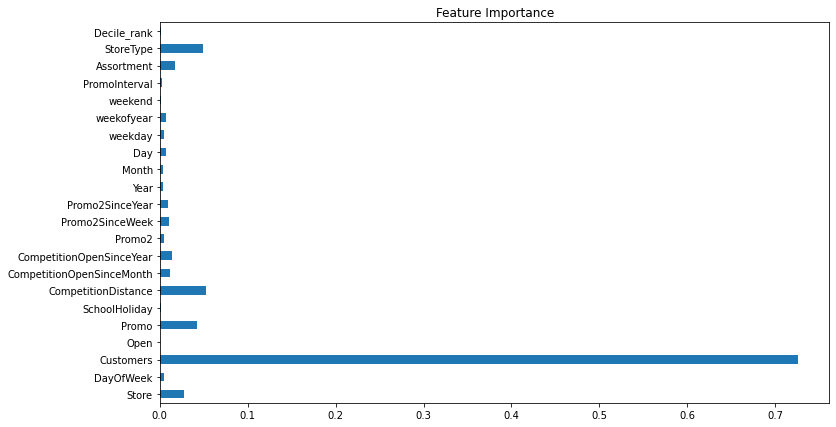

In [25]:
from turtle import title
plt.figure(figsize=(12,7))
feature_importance = pd.Series(feature_importances,index=X_train.columns)
feature_importance.plot(kind='barh',title='Feature Importance')
plt.show()

In [28]:
plt.style.use('seaborn')

<AxesSubplot:title={'center':'Feature Importance'}>

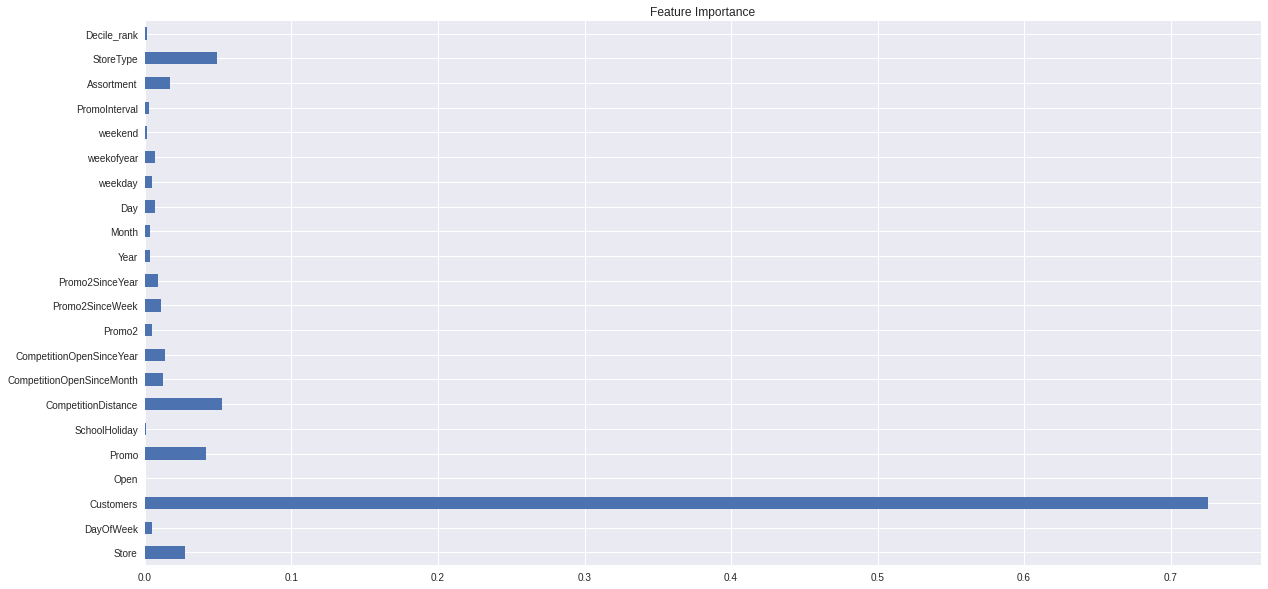

In [30]:
feature_importance.sort_values(by="Importance").plot(kind="barh", 
                                                     x="Feature", 
                                                     y="Importance", 
                                                     title="Feature Importance", 
                                                     legend=False,
                                                     figsize=(20, 10))

In [31]:
loaded_model = preprocess.read_model('2022-09-08-23-17-35')

In [ ]:
print(loaded_model)